In [80]:
import numpy as np 
import astropy.units as units
from astropy.time import Time 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import cloudpickle
import sys 
sys.path.append("helpers")
import data 
import xo_archive
import fit
import plots

from scipy.stats import norm 
from importlib import reload
import exoplanet as xo 
xo.utils.docs_setup()
import lightkurve as lk 

import pymc3 as pm
import pymc3_ext as pmx
#import theano.tensor as tt
import aesara_theano_fallback.tensor as tt
from celerite2.pymc3 import terms, GaussianProcess
import arviz as az
import corner


matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [81]:
reload(plots)

<module 'plots' from '/Users/suissa/radius-valley/helpers/plots.py'>

In [82]:
planet_parameters = xo_archive.get_exoplanet_parameters("L 98-59 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)

search_results = lk.search_lightcurve("L 98-59", mission="TESS", author="SPOC", exptime=120)
lcc = search_results.download_all()
lc = lcc.stitch().remove_nans()


In [83]:
search_results

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,307210830,0.0
1,TESS Sector 05,2018,SPOC,120,307210830,0.0
2,TESS Sector 08,2019,SPOC,120,307210830,0.0
3,TESS Sector 09,2019,SPOC,120,307210830,0.0
4,TESS Sector 10,2019,SPOC,120,307210830,0.0
5,TESS Sector 11,2019,SPOC,120,307210830,0.0
6,TESS Sector 12,2019,SPOC,120,307210830,0.0
...,...,...,...,...,...,...
14,TESS Sector 37,2021,SPOC,120,307210830,0.0


(0.99, 1.02)

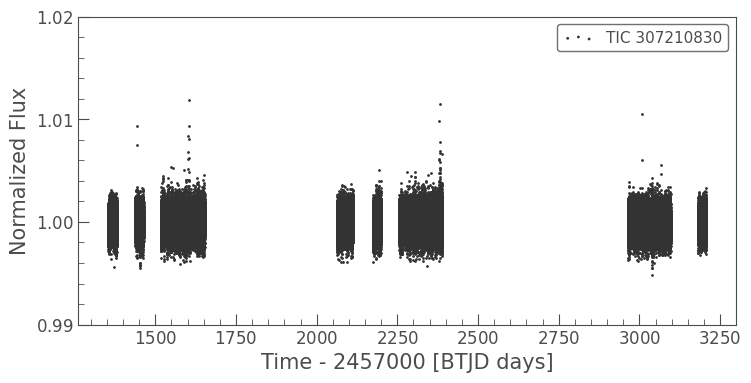

In [84]:
lc.scatter()
#plt.xlim(200,350)
plt.ylim(0.99,1.02)

In [85]:
model, difference, std_calculated, mean_tweaked = data.model_data_residuals(param_lists, lc)
lc_final, flags_5sigma = data.remove_outliers(5, lc, difference, std_calculated, mean_tweaked) 

In [86]:
transit_mask = lc_final.create_transit_mask(period=param_lists['pl_orbper']*units.day, 
                                            transit_time=(Time(param_lists["pl_tranmid"],format="jd")), 
                                            duration=param_lists['pl_trandur']*units.hour)

notransits = lc_final[~transit_mask]
transits = lc_final[transit_mask]

In [87]:
transit_windows_mask = fit.create_transit_windows(lc_final, period=param_lists['pl_orbper']*units.day, 
                                            transit_time=(Time(param_lists["pl_tranmid"],format="jd")), 
                                            duration=param_lists['pl_trandur']*units.hour)

transit_windows = lc_final[transit_windows_mask]

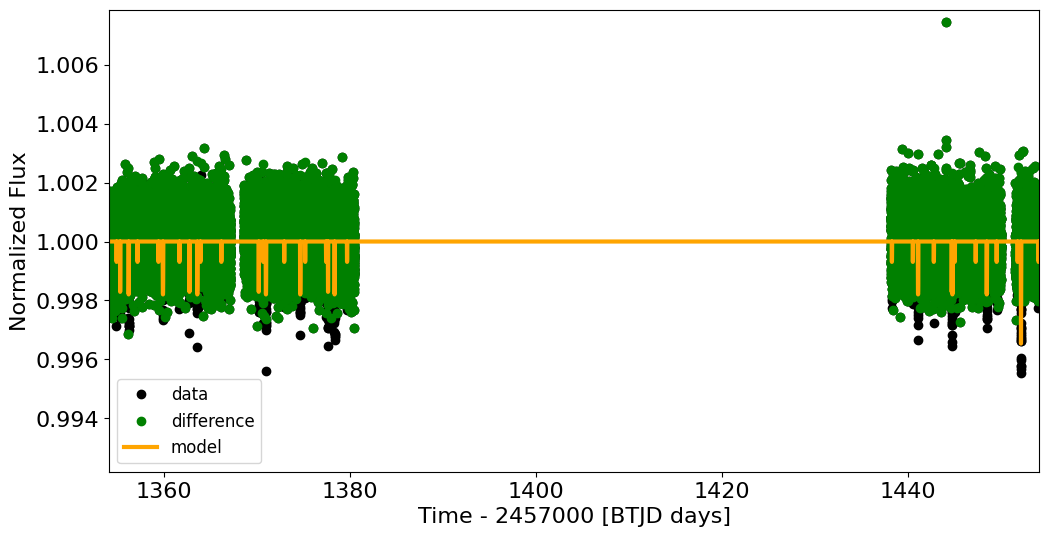

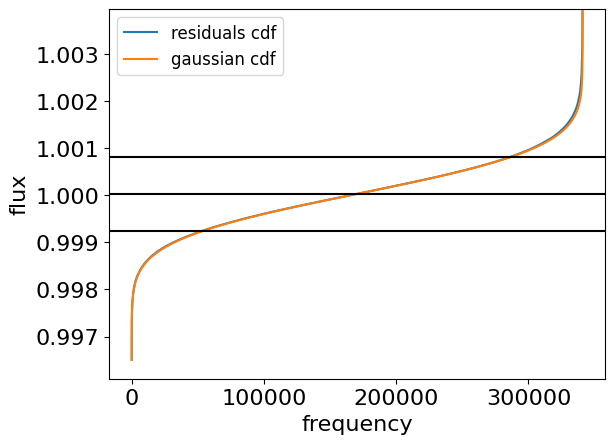

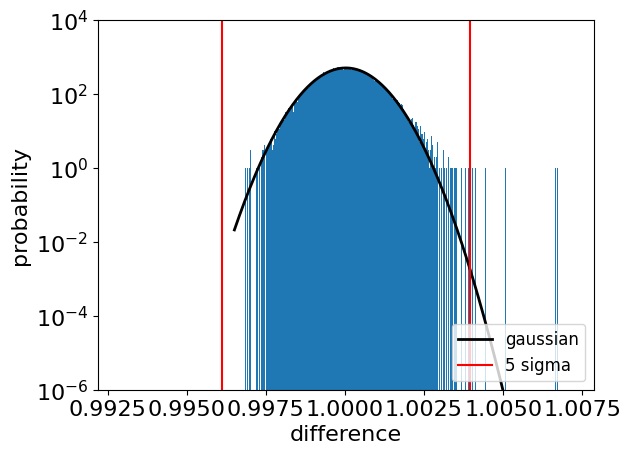

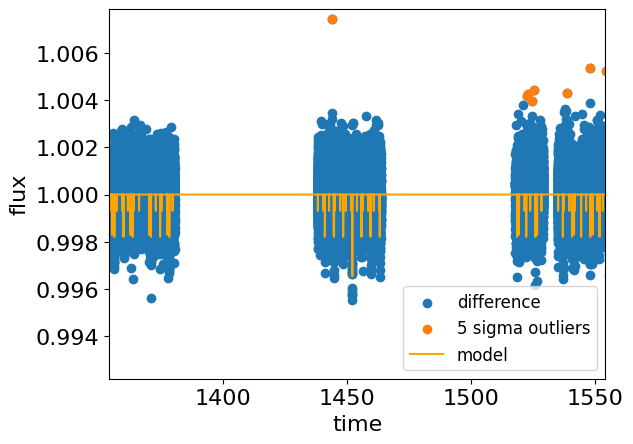

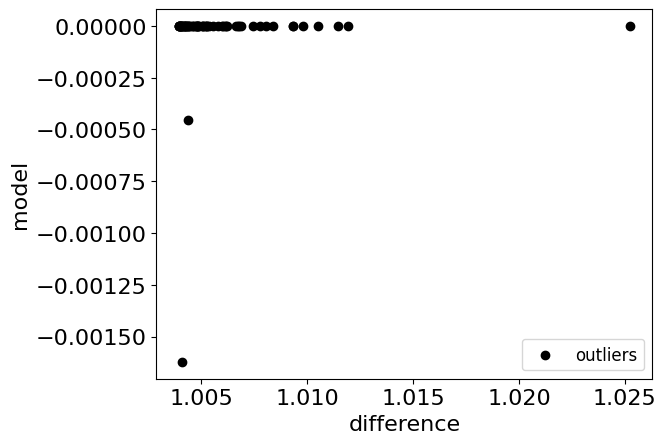

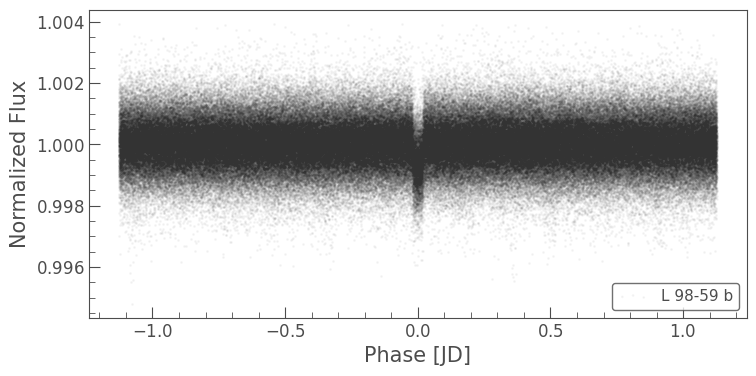

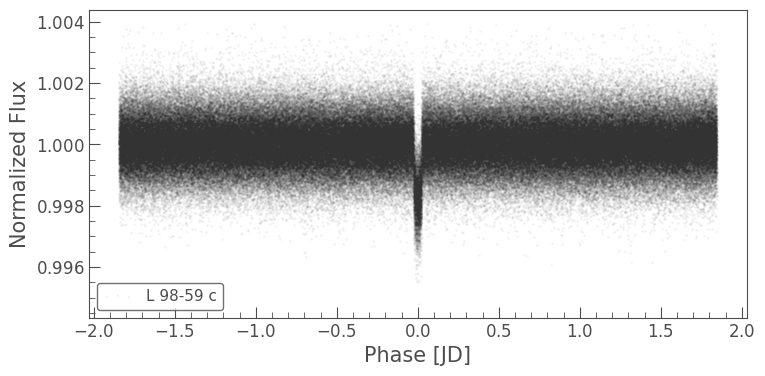

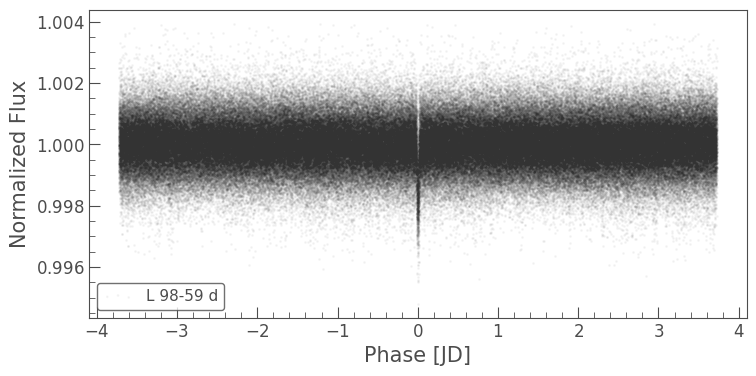

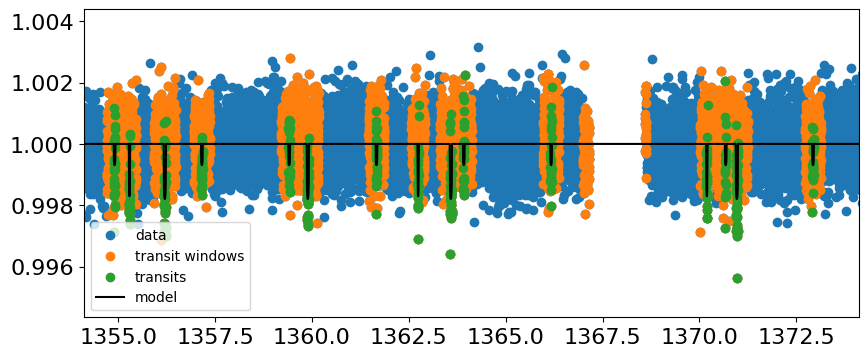

In [88]:
plots.diagnostic_plots(lc, lc_final, transits, transit_windows, param_lists, model, difference, std_calculated, mean_tweaked, sigma=5, flags_nsigma=flags_5sigma)


In [89]:
gp_map_soln = fit.gp(notransits, param_lists, complicated_gp=False)

optimizing logp for variables: [log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 1846228.2066335175 -> 1877625.5802576465
optimizing logp for variables: [log_Q0, log_rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 1877625.5802576465 -> 1877894.2480574462
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 1877894.2480574462 -> 1877897.3858922634


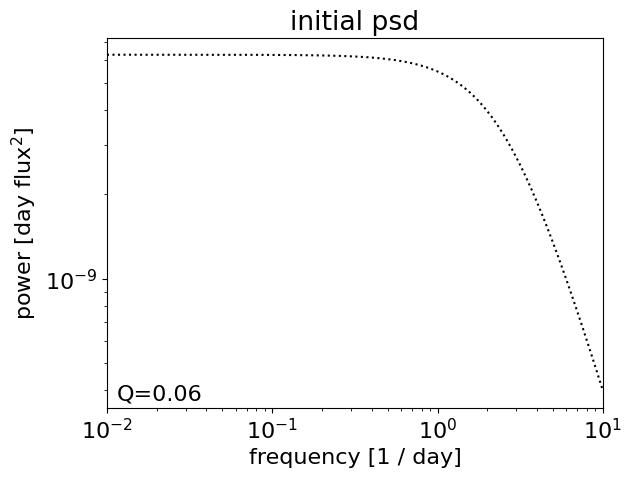

In [90]:
plots.plot_psd(gp_map_soln)

optimizing logp for variables: [mean, t0, b, log_depth, log_rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 667228.2013217418 -> 667832.03983075
optimizing logp for variables: [log_depth, __u_q1, __u_q2, b, r_star, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 667832.03983075 -> 667842.8390424951
optimizing logp for variables: [log_depth, __u_q1, __u_q2, b, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 667842.8390424951 -> 667842.8390424951
optimizing logp for variables: [b, log_depth, r_star, log_rho_star, __u_q2, __u_q1, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 667842.8390424951 -> 667863.5417411865


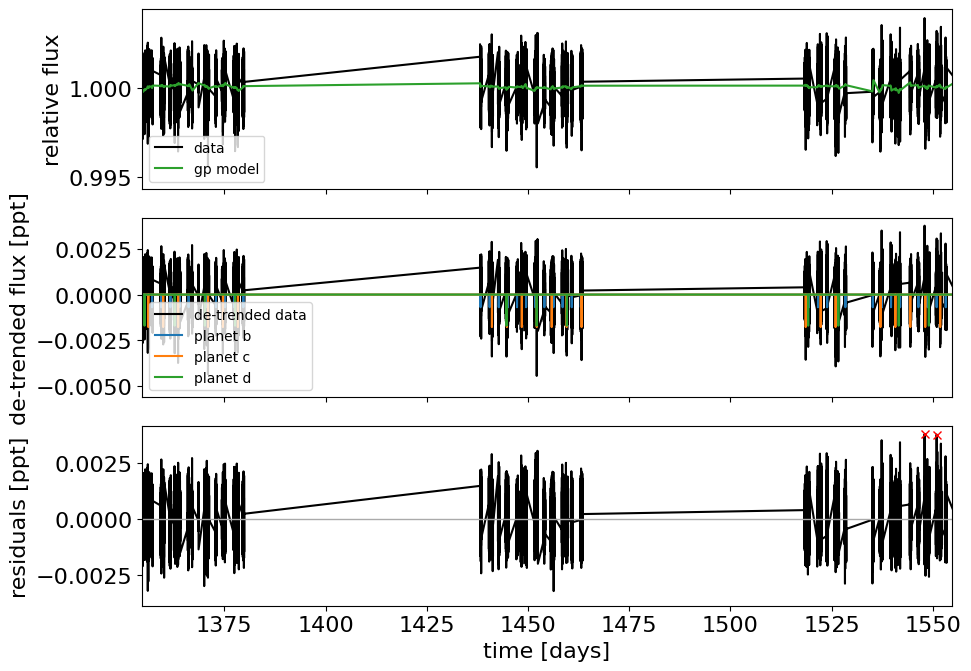

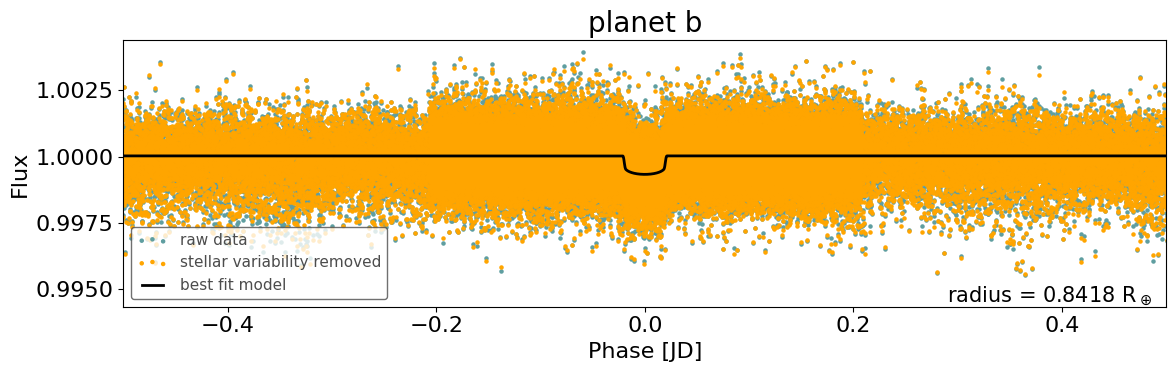

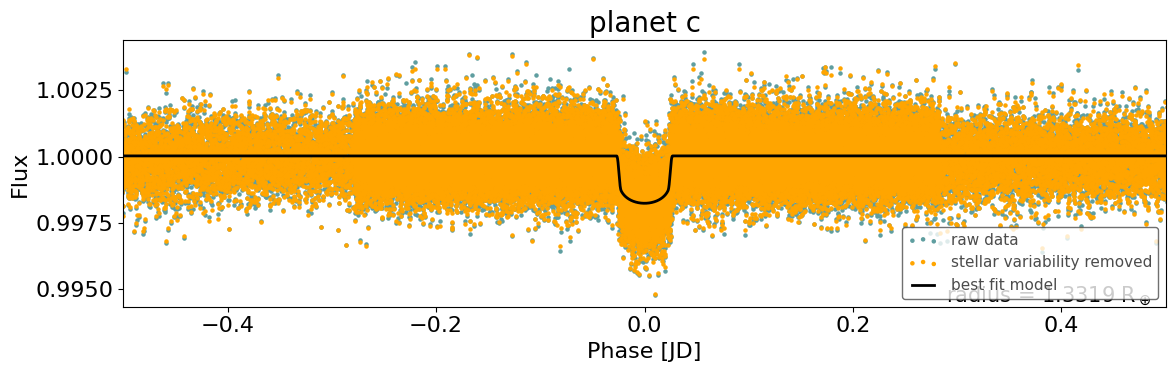

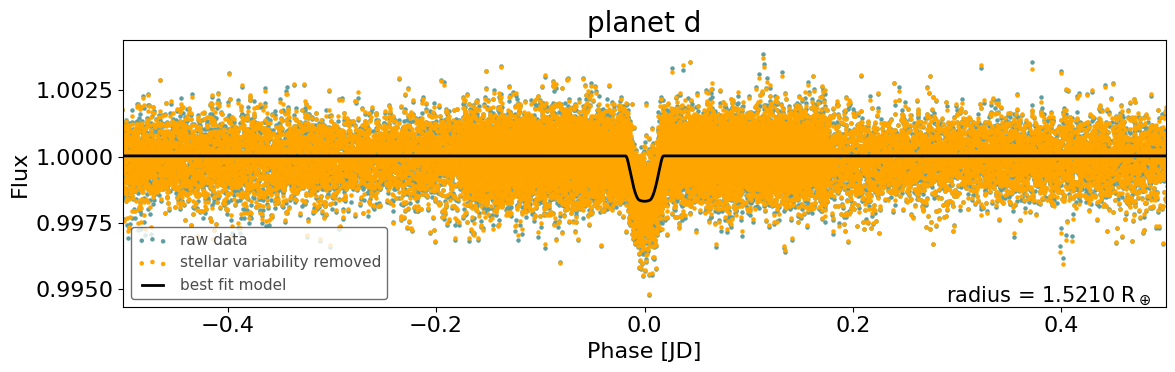

In [91]:
texp = (120*units.s).to(units.day)
map_soln, model, mask = fit.optimise_model(transit_windows, param_lists, gp_map_soln, texp=texp)


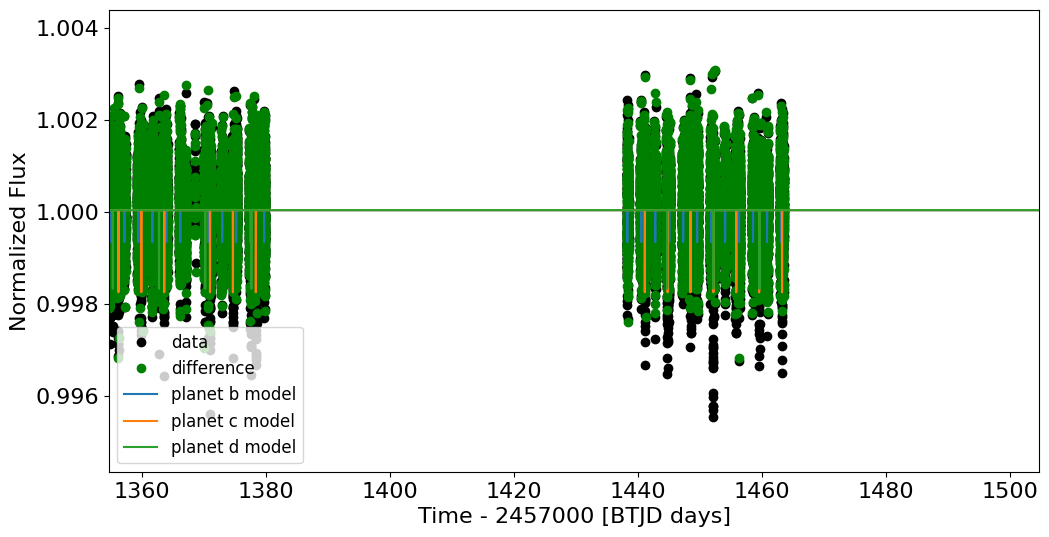

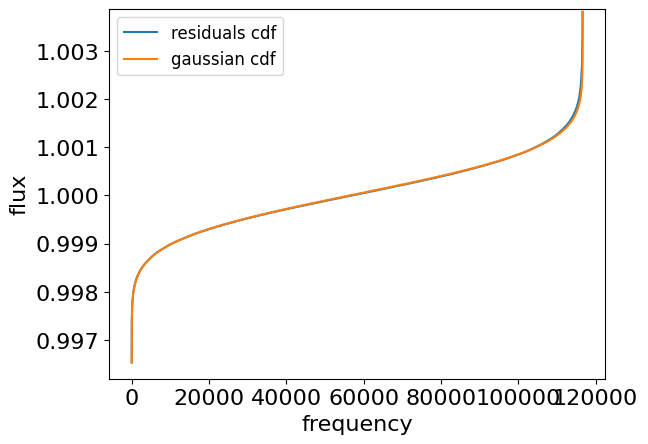

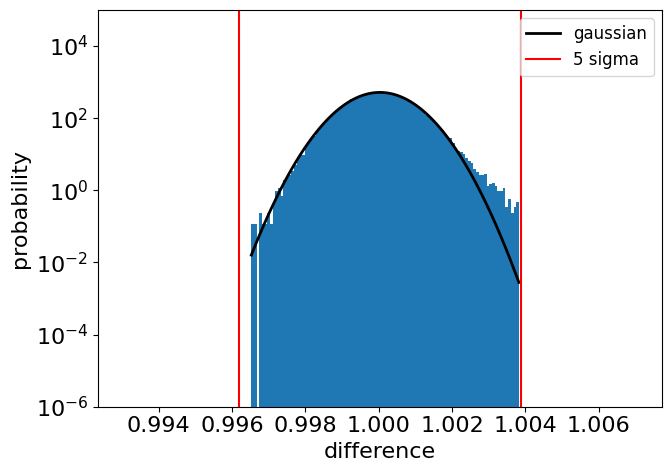

In [92]:
plots.diagnostic_plots_refined(transit_windows, param_lists, map_soln)


In [93]:
param_lists

{'pl_name': ['L 98-59 b', 'L 98-59 c', 'L 98-59 d'],
 'pl_letter': ['b', 'c', 'd'],
 'pl_orbper': [2.2531136, 3.6906777, 7.4507245],
 'pl_orbincl': [87.71, 88.11, 88.449],
 'pl_orbeccen': [0.103, 0.103, 0.074],
 'pl_trandep': [0.0666, 0.1657, 0.1542],
 'pl_tranmid': [2458366.17067, 2458367.27375, 2458362.73974],
 'pl_trandur': [0.992, 1.346, 0.84],
 'pl_ratror': [0.02512, 0.04088, 0.0448],
 'pl_imppar': [0.53, 0.601, 0.922],
 'st_rad': [0.3, 0.3, 0.3],
 'st_mass': [0.27, 0.27, 0.27],
 'st_dens': [12.89991, 12.89991, 12.89991],
 'gaia_id': ['Gaia DR2 5271055243163629056',
  'Gaia DR2 5271055243163629056',
  'Gaia DR2 5271055243163629056'],
 'pl_rade': [0.85, 1.385, 1.521],
 'berger_dens': [14.21251358666482, 14.21251358666482, 14.21251358666482],
 'berger_mass': [0.2789465769568744, 0.2789465769568744, 0.2789465769568744]}

In [94]:
map_soln

{'mean': array(1.00003248),
 't0': array([1366.17037943, 1367.27334678, 1362.73981348]),
 'logP': array([0.81231356, 1.30580918, 2.00831221]),
 '__u_q1_interval__': array(-1.00445689),
 '__u_q2_interval__': array(-0.32223829),
 'log_rho_star': array(2.23920716),
 'r_star': array(0.3),
 'log_depth': array([-7.26940244, -6.32721703, -6.36252835]),
 'b_interval__': array([0.67752212, 0.43313855, 2.82145025]),
 'period': array([2.25311468, 3.69067429, 7.45073144]),
 '__u_q1': array(0.26806605),
 '__u_q2': array(0.42013036),
 'u': array([0.43504578, 0.08270517]),
 'rho_star': array(9.38588681),
 'depth': array([0.00069653, 0.001787  , 0.001725  ]),
 'b': array([0.66318544, 0.60662288, 0.94382401]),
 'ror': array([0.02572561, 0.04070317, 0.04648114]),
 'r_p': array([0.00771768, 0.01221095, 0.01394434]),
 'light_curves': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'gp_pred': array([-2.215453